In [ ]:
#unzip to path
import zipfile

zip_path = 'archive.zip'
extract_path = 'brain_tumour_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [3]:
#load training, validation and test datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory

#split the training portion into training and valid data, as valid data isnt included
#training
ds_train = image_dataset_from_directory(
    'brain_tumour_dataset/Training',
    labels='inferred',
    label_mode='categorical',
    image_size=[128, 128],
    interpolation='nearest', #value of each output pixel taken from closest input pixel
    batch_size=64,
    validation_split=0.2, #reserve 20% of the training portion for validation
    subset="training",
    shuffle=True,
    seed=42
)

#validation
ds_valid = image_dataset_from_directory(
    'brain_tumour_dataset/Training',
    labels='inferred',
    label_mode='categorical',
    image_size=[128, 128],
    interpolation='nearest', #value of each output pixel taken from closest input pixel
    batch_size=64,
    validation_split=0.2, #reserve 20% of the training portion for validation
    subset="validation",
    shuffle=False,
    seed=42
)

ds_test = image_dataset_from_directory(
    'brain_tumour_dataset/Testing',
    labels='inferred',
    label_mode = 'categorical',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
    seed=42
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


In [4]:
#transform data
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

def apply_data_augmentation(image, label):
    image = data_augmentation(image, training=True) #apply augmentation to training ds only
    image, label = convert_to_float(image, label) #convert to float after augmentation
    return image, label


AUTOTUNE = tf.data.experimental.AUTOTUNE #adjust pipeline for optimal performance

ds_train = (
    ds_train
    .map(convert_to_float) #image and label automatically passed in for each image by .map()
    .cache() #cache dataset in memory
    .prefetch(buffer_size=AUTOTUNE) #whilst model trains on current batch new batch can be prepared,
    #buffer size is amount of images prepared, it is adjusted for optimum performance with autotune
)

ds_valid = (
    ds_valid
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_test = (
    ds_test
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


In [ ]:
#building the model
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    #conv block 1
    layers.Conv2D(filters=32, kernel_size=3, padding='same'), #filters starts smaller for basic details, padding='same' means input size = output size, 3 colours channels
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=2), #condense by 1/2
    #layers.Dropout(0.1), #dropout 10% of neurons to prevent overfitting 

    #conv block 2
    layers.Conv2D(filters=64, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=2),
    #layers.Dropout(0.1),

    #conv block 3
    layers.Conv2D(filters=128, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=2),
    #layers.Dropout(0.1),

    layers.Flatten(), #flatten the model for dense layers, as dense layers expect a 1d tensor, not the multi-dimensional feature map produced by the conv blocks

    #3 dense layers to make final prediction
    layers.Dense(units=256),
    layers.BatchNormalization(),
    layers.ReLU(),
    #layers.Dropout(0.2),

    layers.Dense(units=128), #units decreases to avoid overfitting
    layers.BatchNormalization(),
    layers.ReLU(),
    #layers.Dropout(0.2),

    layers.Dense(units=64),
    layers.BatchNormalization(),
    layers.ReLU(),
    #layers.Dropout(0.2),

    layers.Dense(units=4),
    layers.Softmax()
])

In [26]:
#implement early stopping and compile model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True #best weights of model will be kept
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', #what will be used to adjust lr
    factor=0.5, #cut learning rate by half
    patience=2, #wait 2 epochs with no improvement before cutting 
    min_lr=1e-6,
    verbose=1 #prints update when triggered
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
#train the model
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=200, 
    batch_size=64,
    callbacks=[early_stopping, lr_scheduler]
)
model.save("brain_tumour_classifier5.h5") #save the model on the best version from early stopping

Epoch 1/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 66s 920ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 2/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 67s 927ms/step - accuracy: 1.0000 - loss: 8.6280e-04 - val_accuracy: 1.0000 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 3/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 66s 923ms/step - accuracy: 1.0000 - loss: 6.8886e-04 - val_accuracy: 1.0000 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 4/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 66s 921ms/step - accuracy: 1.0000 - loss: 5.7617e-04 - val_accuracy: 1.0000 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 5/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 1.0000 - loss: 4.9402e-04 - val_accuracy: 1.0000 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 6/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 1.0000 - loss: 4.3085e-04 - val_accuracy: 1.0000 - val_loss: 9.1719e-04 - learning_rate: 0.0010


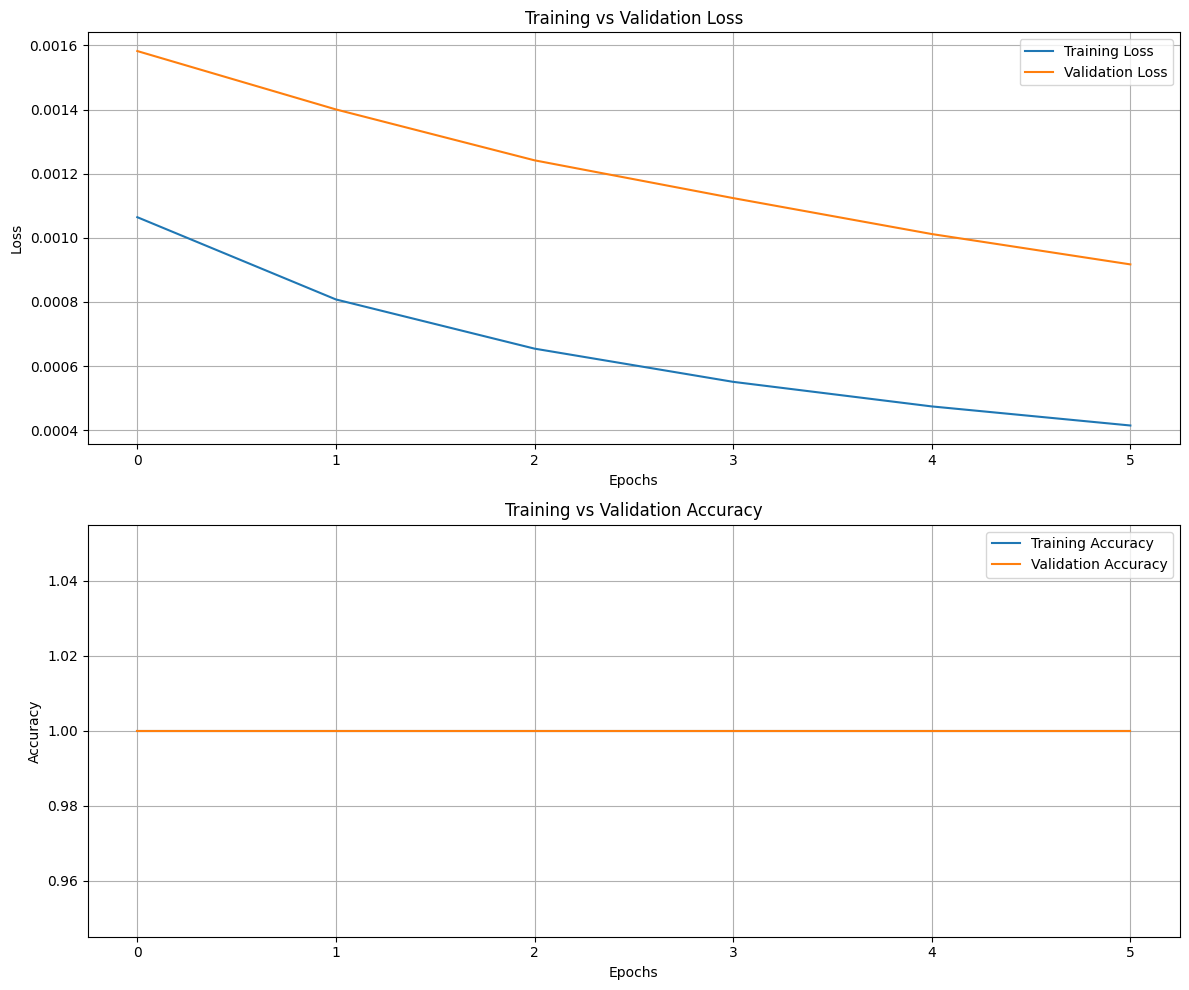

In [29]:
#plotting
import matplotlib.pyplot as plt

#2*1 grid
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

#loss
ax[0].plot(history.history['loss'], label="Training Loss")
ax[0].plot(history.history['val_loss'], label="Validation Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Training vs Validation Loss")
ax[0].legend()
ax[0].grid(True)

#accuracy
ax[1].plot(history.history['accuracy'], label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], label="Validation Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Training vs Validation Accuracy")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [5]:
from tensorflow.keras.models import load_model

#load model for testing
model = load_model('brain_tumour_classifier5.h5')

#evaluate performance
test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9452 - loss: 0.2545
Test Loss: 0.1468978077173233
Test Accuracy: 0.9656750559806824


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


2025-04-12 11:48:20.238081: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


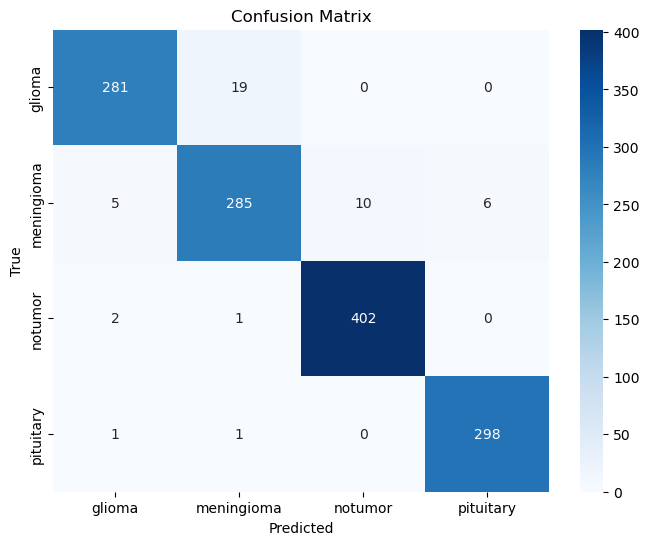

In [ ]:
#confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

model = load_model("brain_tumour_classifier5.h5")

#arrays to hold the predicted classes and actual classes of images in test data
y_true = []
y_pred = []

for images, labels in ds_test:
    preds = model.predict(images) #model makes predictions on each image
    y_true_batch = np.argmax(labels.numpy(), axis=1) #convert the true labels from one-hot encoded values into the same format
    y_pred_batch = np.argmax(preds, axis=1) #convert the preds from arrays of probabilities to an array of the highest probability class from each image

    y_true.extend(y_true_batch)
    y_pred.extend(y_pred_batch)

cm = confusion_matrix(y_true, y_pred) #this will be a numpy array where each cell (i, j) is the amount of times class i is predicted as class j
class_names = ["glioma", "meningioma", "notumor", "pituitary"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names) #produce a colour coded map of where the confusion lies
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [4]:

from tensorflow.keras.models import load_model

model = load_model("models/brain_tumour_classifier5.h5")

model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ (None, 64)             │             

 Total params: 8,526,214 (32.52 MB)

 Trainable params: 8,524,868 (32.52 MB)

 Non-trainable params: 1,344 (5.25 KB)

 Optimizer params: 2 (12.00 B)